In [1]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats

import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations
import os
import requests
import ROOT
import root_numpy as rtnp
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.15/01


In [3]:
dataSelection = 'LAB'
runI = [2151]
start_image_to_read = 0
max_image_to_read = 0
for nRi in range(0,len(runI)):
#############  mean and sigma file generator ############################
    try:
        print ('Download and open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
        f = cy.swift_read_root_file(cy.swift_root_file(dataSelection, runI[nRi]))
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        imageName = cy.root_TH2_name(f)
        max_image=len(imageName)
        print ("# of Image Files: %d TH2" % (max_image))
        nImag=max_image
    
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
    if max_image_to_read != 0:
        nImag = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (start_image_to_read, nImag))
    
    m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
    s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

    n0 = 0
    for iImg in range(start_image_to_read, nImag):
        image = rtnp.hist2array(f.Get(imageName[iImg])).T
        m_image += image
        s_image += image**2 
        if n0 > 0:  # print progress and debung info for poit 200, 200...
            print ("Image[200,200]: %d => %.2f %.2f %.2f " % (iImg,
                                             image[200,200],
                                             np.sqrt((s_image[200,200] - 
                                                     m_image[200,200]**2 
                                                      / (n0+1)) / n0),
                                             m_image[200,200]/(n0+1),
                                             ))
        n0 += 1
    m_image = m_image/n0
    s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))
    
###### print Info and Save OutPut ######################################
    
    print ("sigma %f" % (s_image[200,200]))
    fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
    cy.write_image_h5(fileoutm, m_image)
    fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
    cy.write_image_h5(fileouts, s_image)
    print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))

Download and open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02151.root
Find Keys: 204
# of Image Files: 102 TH2
Image[200,200]: 1 => 96.00 1.41 97.00 
Image[200,200]: 2 => 105.00 4.73 99.67 
Image[200,200]: 3 => 100.00 3.86 99.75 
Image[200,200]: 4 => 98.00 3.44 99.40 
Image[200,200]: 5 => 100.00 3.08 99.50 
Image[200,200]: 6 => 98.00 2.87 99.29 
Image[200,200]: 7 => 100.00 2.67 99.38 
Image[200,200]: 8 => 100.00 2.51 99.44 
Image[200,200]: 9 => 97.00 2.49 99.20 
Image[200,200]: 10 => 96.00 2.55 98.91 
Image[200,200]: 11 => 121.00 6.82 100.75 
Image[200,200]: 12 => 96.00 6.67 100.38 
Image[200,200]: 13 => 98.00 6.44 100.21 
Image[200,200]: 14 => 101.00 6.20 100.27 
Image[200,200]: 15 => 98.00 6.02 100.12 
Image[200,200]: 16 => 100.00 5.83 100.12 
Image[200,200]: 17 => 98.00 5.68 100.00 
Image[200,200]: 18 => 98.00 5.54 99.89 
Image[200,200]: 19 => 101.00 5.39 99.95 
Image[200,200]: 20 => 94.00 5.42 99.67 
Image[200,200

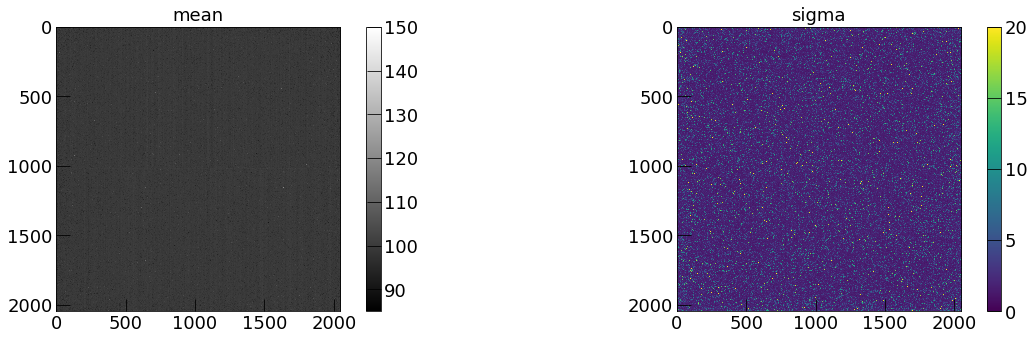

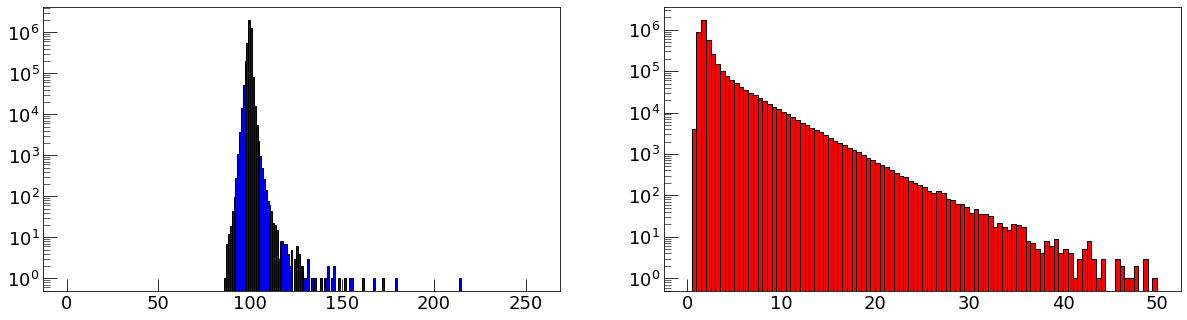

In [5]:
cy.set_atlas_style('long')
run = 2151
try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    imagem = cy.read_image_h5(fileoutm)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    images = cy.read_image_h5(fileouts)
except:
    print ("No file for run %s, run script runs-pedestals.ipynb" % run)


fig, ax = plt.subplots(1,2)
im = ax[0].imshow(imagem, cmap="gray", vmin=85,vmax=150)
fig.colorbar(im, ax=ax[0])
ax[0].set_title("mean")
ax[1].set_title("sigma")
im = ax[1].imshow(images, vmin=0,vmax=20)
fig.colorbar(im, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1,2)
ax[0].hist(imagem.ravel(), bins=256, range=(0.0, 256.0), fc='b', ec='k')
ax[1].hist(images.ravel(), bins=100, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")

plt.show()